 # Ejemplo de problema de clasificación multietiqueta

In [18]:
import tensorflow as tf
print(tf.__version__)

2.18.0


### Imports necesarios

In [19]:
import os
#!pip install kagglehub
import kagglehub
#!pip install pandas
import pandas as pd
import re
import random
import numpy as np
#!pip install matplotlib
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#!pip install scikit-learn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, hamming_loss, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

### Importamos el dataset desde kaggle

In [20]:
# Download latest version
path = kagglehub.dataset_download("ashpalsingh1525/imdb-movies-dataset")

print("Path to dataset files:", path)

# Listar los archivos descargados
print("Archivos en el directorio:", os.listdir(path))

Path to dataset files: C:\Users\domid\.cache\kagglehub\datasets\ashpalsingh1525\imdb-movies-dataset\versions\1
Archivos en el directorio: ['imdb_movies.csv']


In [21]:
# Ruta completa del archivo CSV
csv_path = os.path.join(path, "imdb_movies.csv")

# Cargar el dataset
df = pd.read_csv(csv_path)

# Mostrar los nombres de las columnas
print("Columnas del dataset:", df.columns)

# Mostrar las primeras filas para ver la estructura
df.info()
display(df.head())

Columnas del dataset: Index(['names', 'date_x', 'score', 'genre', 'overview', 'crew', 'orig_title',
       'status', 'orig_lang', 'budget_x', 'revenue', 'country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


### MultiLabelBinarizer para las columnas genre y crew

In [22]:
""""
# Procesar columna 'genre'
df["genre"] = df["genre"].fillna("Desconocido")
df["genre"] = df["genre"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\xa0', ' ', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'[\[\]\'\"]', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\s+', ' ', x))
df["genre"] = df["genre"].apply(lambda x: x.strip())

num_nulos_genre = df["genre"].isna().sum()
print(f"Cantidad de valores nulos en 'genre': {num_nulos_genre}")

df["genre"] = df["genre"].apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)

mlb_genre = MultiLabelBinarizer()
genres_encoded = mlb_genre.fit_transform(df["genre"])
genres_df = pd.DataFrame(genres_encoded, columns=mlb_genre.classes_)
df = pd.concat([df, genres_df], axis=1)

if "nan" in df.columns:
    df.drop(columns=["nan"], inplace=True)

# Procesar columna 'crew'
df["crew"] = df["crew"].fillna("Desconocido")
df["crew"] = df["crew"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'\\xa0', ' ', x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'\\', '', x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'[\[\]\'\"]', '', x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'\s+', ' ', x))
df["crew"] = df["crew"].apply(lambda x: x.strip())

num_nulos_crew = df["crew"].isna().sum()
print(f"Cantidad de valores nulos en 'crew': {num_nulos_crew}")

df["crew"] = df["crew"].apply(lambda x: [person.strip() for person in x.split(',')] if isinstance(x, str) else x)

mlb_crew = MultiLabelBinarizer()
crew_encoded = mlb_crew.fit_transform(df["crew"])
crew_df = pd.DataFrame(crew_encoded, columns=mlb_crew.classes_)
df = pd.concat([df, crew_df], axis=1)

if "nan" in df.columns:
    df.drop(columns=["nan"], inplace=True)

display(df.head())
df.info()
"""

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
C:\Users\domid\AppData\Local\Temp\ipykernel_16840\366265518.py:1: SyntaxWarning: invalid escape sequence '\['
  """"


'"\n# Procesar columna \'genre\'\ndf["genre"] = df["genre"].fillna("Desconocido")\ndf["genre"] = df["genre"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'\\xa0\', \' \', x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'\\\', \'\', x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'[\\[\\]\'"]\', \'\', x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'\\s+\', \' \', x))\ndf["genre"] = df["genre"].apply(lambda x: x.strip())\n\nnum_nulos_genre = df["genre"].isna().sum()\nprint(f"Cantidad de valores nulos en \'genre\': {num_nulos_genre}")\n\ndf["genre"] = df["genre"].apply(lambda x: [genre.strip() for genre in x.split(\',\')] if isinstance(x, str) else x)\n\nmlb_genre = MultiLabelBinarizer()\ngenres_encoded = mlb_genre.fit_transform(df["genre"])\ngenres_df = pd.DataFrame(genres_encoded, columns=mlb_genre.classes_)\ndf = pd.concat([df, genres_df], axis=1)\n\nif "nan" in df.columns:\n    df.drop(col

### ENCODING

In [23]:
# 1️⃣ Procesar la columna 'genre' para extraer las etiquetas multietiqueta y crear 'y'
df["genre"] = df["genre"].fillna("Desconocido")
df["genre"] = df["genre"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\xa0', ' ', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'[\[\]\'\"]', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\s+', ' ', x))
df["genre"] = df["genre"].apply(lambda x: x.strip())

# Convertir la columna 'genre' en listas de géneros
df["genre"] = df["genre"].apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)

# Aplicar MultiLabelBinarizer para los géneros
mlb_genre = MultiLabelBinarizer()
genres_encoded = mlb_genre.fit_transform(df["genre"])

# Crear un DataFrame con las columnas de géneros binarizados
genres_df = pd.DataFrame(genres_encoded, columns=mlb_genre.classes_)

# Añadir las columnas binarizadas de género al DataFrame original
df = pd.concat([df, genres_df], axis=1)

# Eliminar columna 'genre' después de binarizarla
df.drop(columns=["genre"], inplace=True)

# 2️⃣ Crear el DataFrame X (con las demás características)
# 1. Convertir 'date_x' en un objeto datetime y extraer sus componentes (year, month, day)
df['date_x'] = pd.to_datetime(df['date_x'], errors='coerce')
df['year'] = df['date_x'].dt.year
df['month'] = df['date_x'].dt.month
df['day'] = df['date_x'].dt.day

# 2. Incluir One-Hot Encoding solo a las variables categóricas
categorical_cols = ["orig_lang", "country"]  # Excluimos las columnas de fecha (year, month, day)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 3. Eliminar columnas irrelevantes (names, orig_title, overview, status, date_x)
df.drop(columns=["names", "orig_title", "overview", "status", "date_x","crew"], inplace=True)

# 3️⃣ Crear X e y
X = df.drop(columns=mlb_genre.classes_.tolist())  # X contiene todo menos los géneros
y = genres_df  # y es solo los géneros binarizados

# Mostrar información de X e y
print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)

# Mostrar las primeras filas de X e y para verificar
display(X.head())
display(y.head())

# 4️⃣ Guardar X e y por separado en archivos CSV
X.to_csv("X_data.csv", index=False)
y.to_csv("y_data.csv", index=False)

###DESAJUSTE DE PESOS EN LA VARIABLE Y
# Contar la cantidad de 1s (géneros presentes) en cada columna de 'genres_df'
genre_counts = genres_df.sum(axis=0)

# Mostrar la cantidad de géneros por tipo
print("Distribución de géneros:")
print(genre_counts)


Tamaño de X: (10178, 118)
Tamaño de y: (10178, 20)


,score,budget_x,revenue,year,month,day,orig_lang_ Basque,orig_lang_ Bengali,"orig_lang_ Bokmål, Norwegian, Norwegian Bokmål",orig_lang_ Cantonese,...,country_SU,country_TH,country_TR,country_TW,country_UA,country_US,country_UY,country_VN,country_XC,country_ZA
0,73.0,75000000.0,2.716167e+08,2023,3,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,78.0,460000000.0,2.316795e+09,2022,12,15,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,76.0,100000000.0,7.244590e+08,2023,4,5,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,70.0,12300000.0,3.420000e+07,2023,1,5,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,61.0,77000000.0,3.409420e+08,2023,3,17,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


,Action,Adventure,Animation,Comedy,Crime,Desconocido,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Distribución de géneros:
Action             2752
Adventure          1890
Animation          1468
Comedy             2943
Crime              1272
Desconocido          85
Documentary         217
Drama              3812
Family             1407
Fantasy            1382
History             422
Horror             1554
Music               277
Mystery             862
Romance            1576
Science Fiction    1261
TV Movie            212
Thriller           2605
War                 282
Western             131
dtype: int64


### Entrenamiento

In [24]:
# 1️⃣ **X** y **y** ya están preparados en este punto
# X contiene las características (todas menos las de género)
# y contiene las etiquetas binarizadas de los géneros

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2️⃣ Calcular los pesos de las clases
# Obtener los nombres de las clases de género (columnas de y_train)
genre_labels = y_train.columns

# Calcular los pesos de las clases basados en la frecuencia de las clases en el conjunto de entrenamiento
genre_weights = compute_class_weight('balanced', classes=np.arange(len(genre_labels)), y=y_train.values.argmax(axis=1))

# Crear un diccionario con los nombres de las clases y sus pesos
class_weight_dict = dict(zip(genre_labels, genre_weights))
print(f"Class weights: {class_weight_dict}")

# 3️⃣ Normalizar las características numéricas (X)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4️⃣ Crear el modelo de red neuronal
model = Sequential()

# Añadir las capas del modelo
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))  # Aumentar unidades
model.add(Dropout(0.5))  # Regularización con Dropout
model.add(Dense(256, activation='relu'))  # Aumentar unidades
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))  # Aumentar unidades

# Última capa con el número correcto de unidades (20 clases)
model.add(Dense(20, activation='sigmoid'))  # 20 clases para multilabel

# 5️⃣ Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6️⃣ Entrenar el modelo con EarlyStopping y los pesos de las clases
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=50, 
    batch_size=8, 
    validation_data=(X_test_scaled, y_test), 
    callbacks=[early_stopping],
    class_weight=class_weight_dict  # Aquí pasamos el diccionario de pesos
)

# 7️⃣ Mostrar el rendimiento del modelo
print(f"Última val_loss: {history.history['val_loss'][-1]}")
print(f"Última val_accuracy: {history.history['val_accuracy'][-1]}")

# 8️⃣ Evaluar el modelo en los datos de prueba
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

Class weights: {'Action': np.float64(0.18370938628158845), 'Adventure': np.float64(0.5630705394190871), 'Animation': np.float64(0.8446058091286307), 'Comedy': np.float64(0.29099356683345246), 'Crime': np.float64(0.9762589928057553), 'Desconocido': np.float64(5.654166666666667), 'Documentary': np.float64(2.626451612903226), 'Drama': np.float64(0.25684542586750786), 'Family': np.float64(19.385714285714286), 'Fantasy': np.float64(6.263076923076923), 'History': np.float64(40.71), 'Horror': np.float64(0.6292117465224111), 'Music': np.float64(58.15714285714286), 'Mystery': np.float64(7.018965517241379), 'Romance': np.float64(3.914423076923077), 'Science Fiction': np.float64(8.142), 'TV Movie': np.float64(50.8875), 'Thriller': np.float64(4.1969072164948455), 'War': np.float64(203.55), 'Western': np.float64(16.9625)}
Epoch 1/50


c:\Users\domid\Desktop\multitarget\multitarget-crrtNBcT\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2027 - loss: 0.3685 - val_accuracy: 0.2431 - val_loss: 0.3231
Epoch 2/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2258 - loss: 0.3267 - val_accuracy: 0.2726 - val_loss: 0.3163
Epoch 3/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2563 - loss: 0.3198 - val_accuracy: 0.2451 - val_loss: 0.3151
Epoch 4/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2547 - loss: 0.3179 - val_accuracy: 0.2672 - val_loss: 0.3129
Epoch 5/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2705 - loss: 0.3128 - val_accuracy: 0.2579 - val_loss: 0.3123
Epoch 6/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2670 - loss: 0.3128 - val_accuracy: 0.2603 - val_loss: 0.3107
Epoch 7/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2686 - loss: 0.3131 - val_accuracy: 0.2692 - val_loss: 0.3106
Epoch 8/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2687 - loss: 0.3095 - val_accurac

In [25]:
# Realizar las predicciones
y_pred_prob = model.predict(X_test)

# Convertir las probabilidades a etiquetas binarias (0 o 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculo de las métricas
subset_accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='samples')
recall = recall_score(y_test, y_pred, average='samples')
f1 = f1_score(y_test, y_pred, average='samples')

print(f"Subset Accuracy: {subset_accuracy:.2f}")
print(f"Hamming Loss: {hamming}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Subset Accuracy: 0.01
Hamming Loss: 0.22664538310412574
Precision: 0.18795022920759658
Recall: 0.1912082514734774
F1 Score: 0.18102268829184348


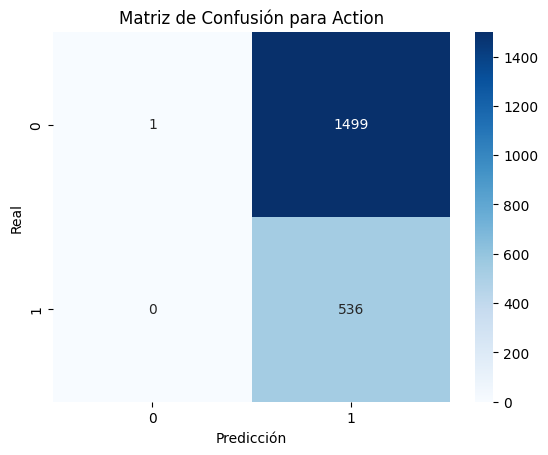

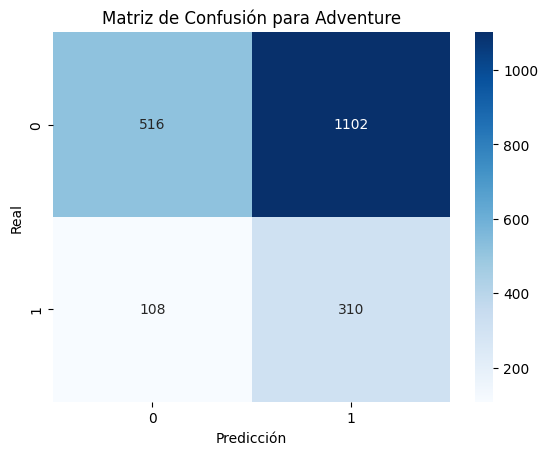

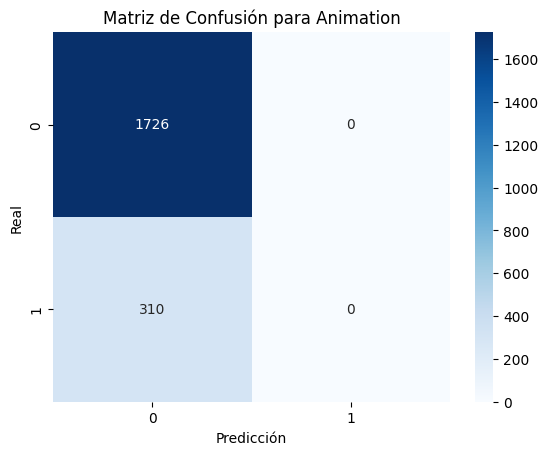

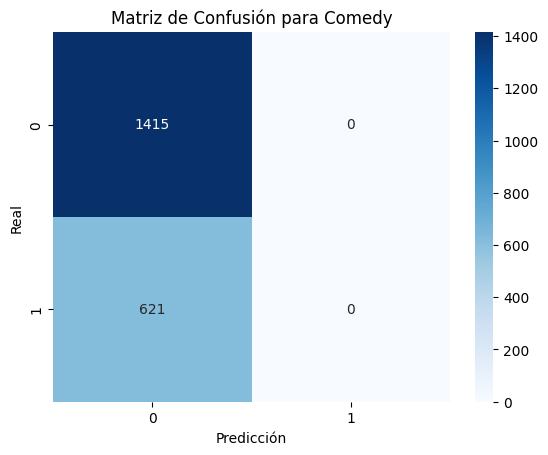

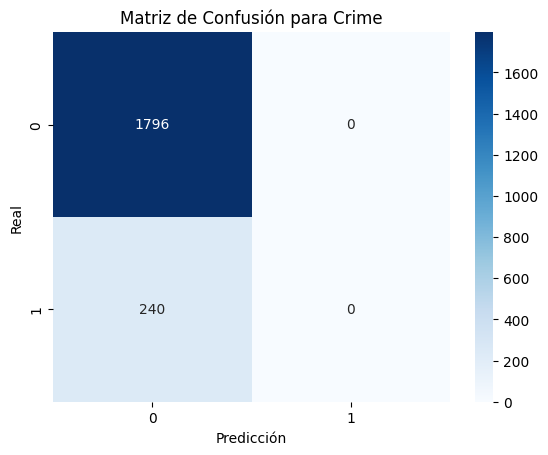

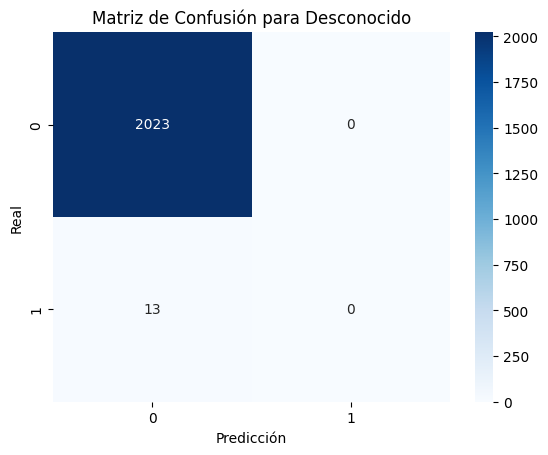

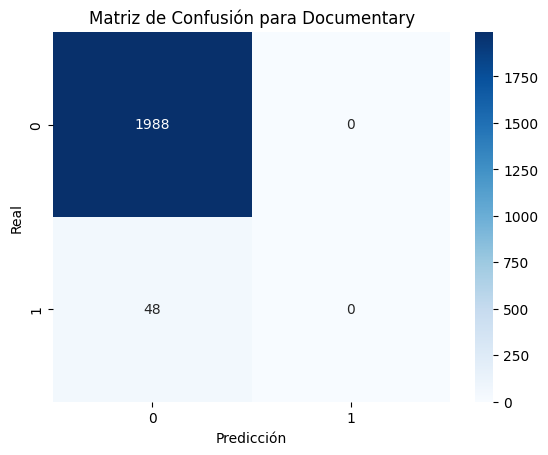

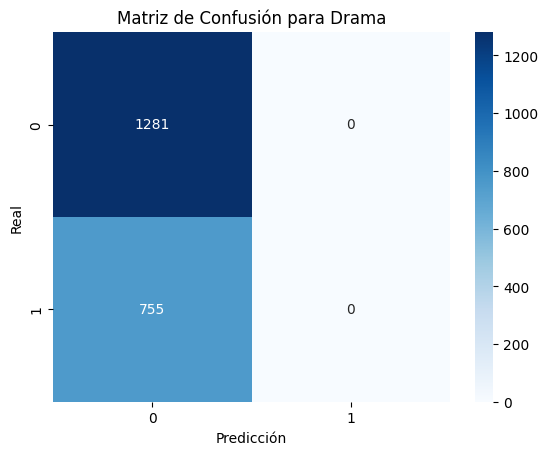

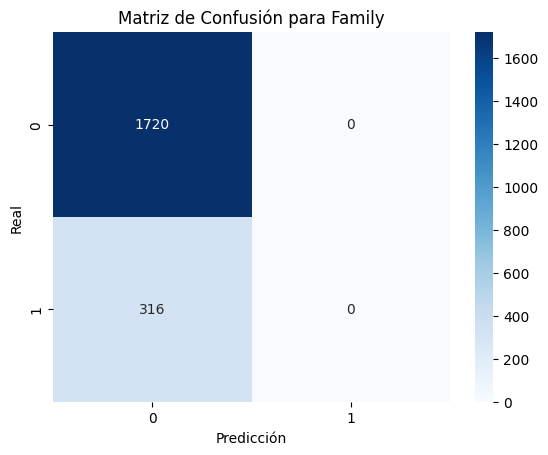

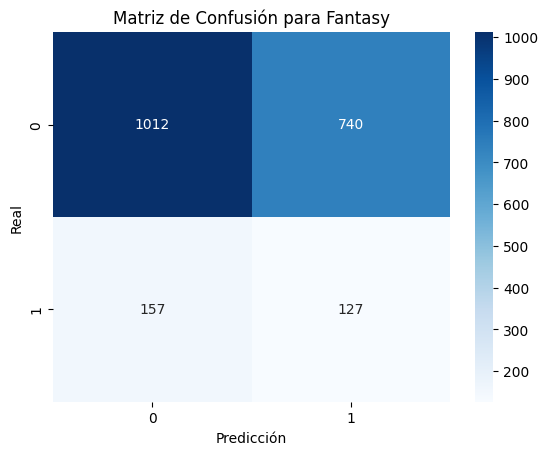

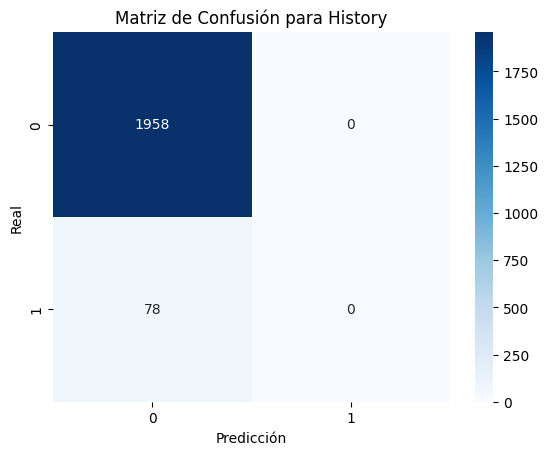

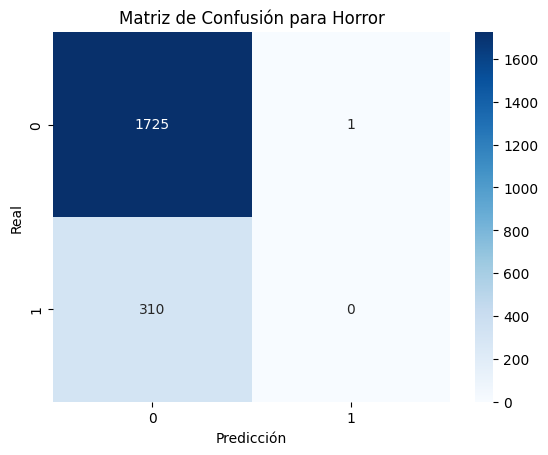

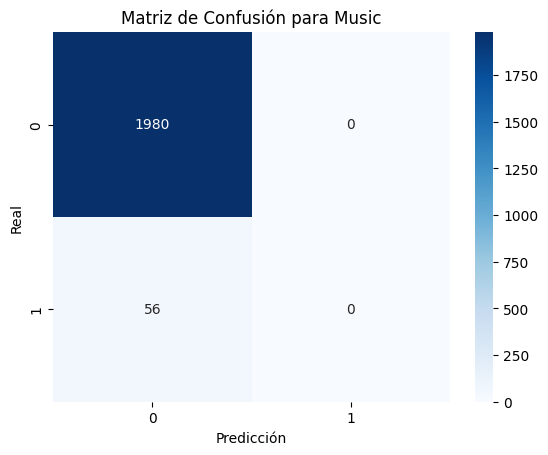

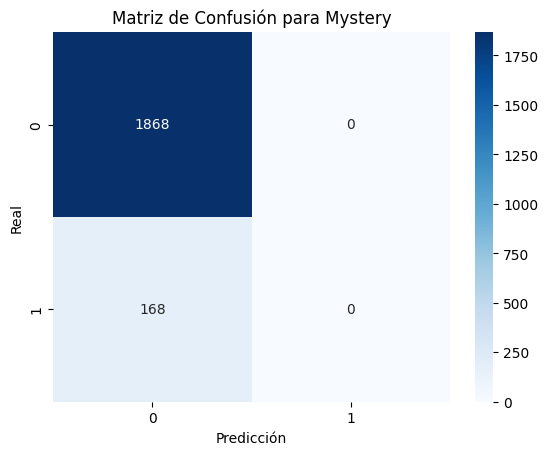

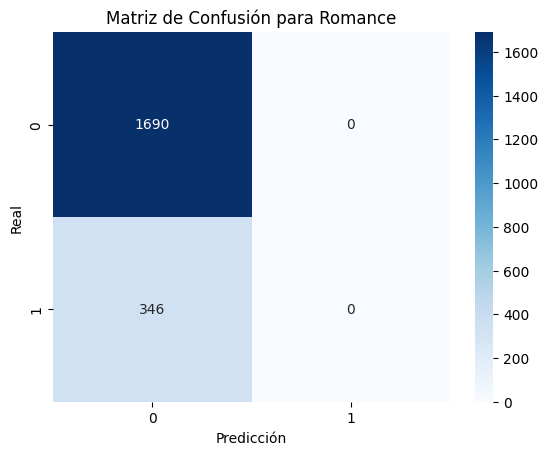

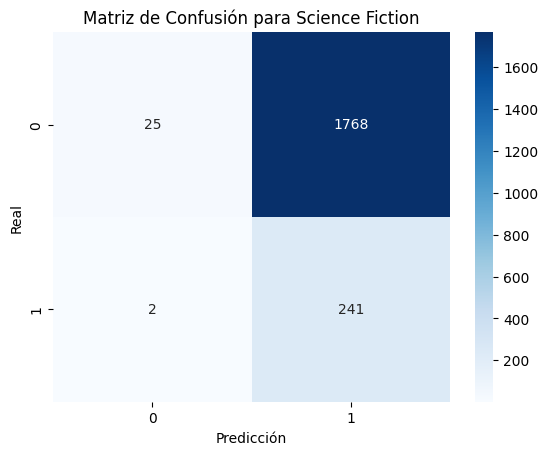

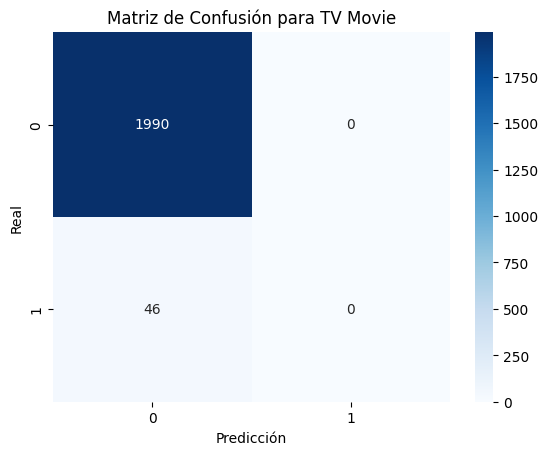

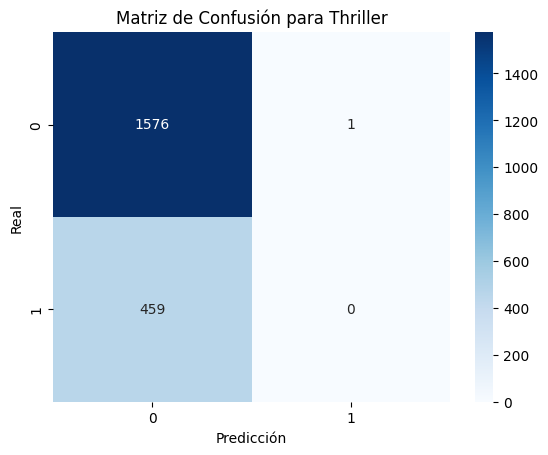

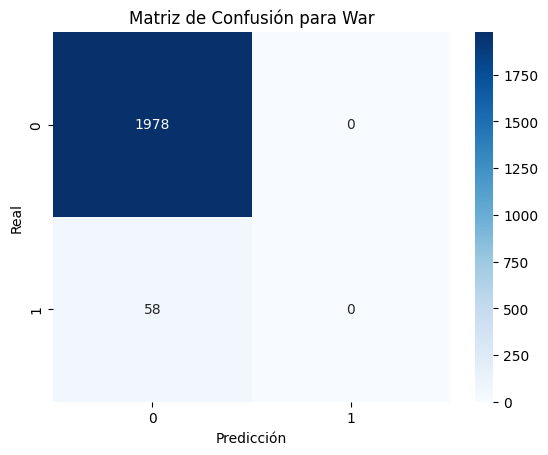

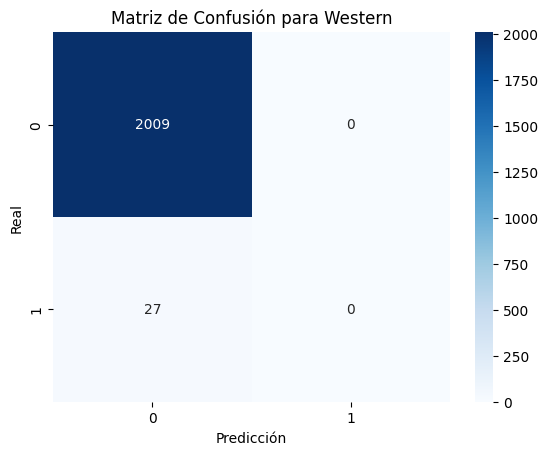

In [26]:
# Generar la matriz de confusión para cada etiqueta
for i, label in enumerate(y.columns):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matriz de Confusión para {label}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


In [27]:
# Realizar las predicciones
y_pred_prob = model.predict(X_test)

# Convertir las probabilidades a etiquetas binarias (0 o 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Reporte de clasificación
report = classification_report(y_test, y_pred, target_names=y.columns)

# Mostrar el reporte
print(report)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
                 precision    recall  f1-score   support

         Action       0.26      1.00      0.42       536
      Adventure       0.22      0.74      0.34       418
      Animation       0.00      0.00      0.00       310
         Comedy       0.00      0.00      0.00       621
          Crime       0.00      0.00      0.00       240
    Desconocido       0.00      0.00      0.00        13
    Documentary       0.00      0.00      0.00        48
          Drama       0.00      0.00      0.00       755
         Family       0.00      0.00      0.00       316
        Fantasy       0.15      0.45      0.22       284
        History       0.00      0.00      0.00        78
         Horror       0.00      0.00      0.00       310
          Music       0.00      0.00      0.00        56
        Mystery       0.00      0.00      0.00       168
        Romance       0.00      0.00      0.00       346
Science Fiction       0.12      0.99      0.21

c:\Users\domid\Desktop\multitarget\multitarget-crrtNBcT\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
